In [1]:
!cat /proc/meminfo

MemTotal:       32949048 kB
MemFree:        31251288 kB
MemAvailable:   31993780 kB
Buffers:          121920 kB
Cached:           946340 kB
SwapCached:            0 kB
Active:           975504 kB
Inactive:         543836 kB
Active(anon):     451092 kB
Inactive(anon):       48 kB
Active(file):     524412 kB
Inactive(file):   543788 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               668 kB
Writeback:             0 kB
AnonPages:        451076 kB
Mapped:           119824 kB
Shmem:                60 kB
Slab:              97924 kB
SReclaimable:      75408 kB
SUnreclaim:        22516 kB
KernelStack:        3952 kB
PageTables:         5604 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    16474524 kB
Committed_AS:    1659380 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

In [18]:
!pip install xgboost msgpack lightgbm

    100% |████████████████████████████████| 737kB 22.9MB/s ta 0:00:01
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import gc

from sklearn import preprocessing as prp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (accuracy_score, r2_score, confusion_matrix,
f1_score, recall_score, precision_score)

import os
import boto3
import re

import xgboost as xgb

from decomposition.var_clus import VarClus

# ruta de trabajo en s3
bucket = 'boi-banregio'

target = 'BMI'
seed = 0

# s3 resource
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

In [7]:
def get_xgb_feat_importances(clf):
    if isinstance(clf, xgb.XGBModel):
        # clf has been created by calling
        # xgb.XGBClassifier.fit() or xgb.XGBRegressor().fit()
        fscore = clf.booster().get_fscore()
    else:
        # clf has been created by calling xgb.train.
        # Thus, clf is an instance of xgb.Booster.
        fscore = clf.get_fscore()

    feat_importances = []
    for ft, score in fscore.items():
        feat_importances.append({'Feature': ft, 'Importance': score})
    feat_importances = pd.DataFrame(feat_importances)
    feat_importances = feat_importances.sort_values(
        by='Importance', ascending=False).reset_index(drop=True)
    # Divide the importances by the sum of all importances
    # to get relative importances. By using relative importances
    # the sum of all importances will equal to 1, i.e.,
    # np.sum(feat_importances['importance']) == 1
    feat_importances['Importance'] /= feat_importances['Importance'].sum()
    # Print the most important features and their importances
    print(feat_importances.head())
    return feat_importances

In [8]:
# Aquí colocamos la ruta de nuestro directorio, el nombre de nuestro archivo y si tiene o no cabecera
prefix = 'datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION'

In [9]:
target_file_name = "TARGETS.csv"
target_file_key = "{}/{}".format(prefix, target_file_name)
target_obj = s3_bucket_resource.Object(target_file_key).get()
data_target = pd.read_csv(io.BytesIO(target_obj['Body'].read())).loc[:,[target]]

In [10]:
data_file_name = "PROCESSED_DATA/DATA_PREPROCESSED_PART{}.csv".format(0)
data_file_key = "{}/{}".format(prefix, data_file_name)
print(data_file_key)
    
print('Loading data')
data_part_obj = s3_bucket_resource.Object(data_file_key).get()
data_part = pd.read_csv(io.BytesIO(data_part_obj['Body'].read()))
display(data_part)

datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART0.csv
Loading data


,AVG_PND_MENOS_BAL_12M,AVG_PND_MAS_BAL_12M,AVG_BAL_12M,MAX_D_CRED_LIM_TO_BAL_03M,AVG_D_CRED_LIM_TO_BAL_06M,AVG_R_BAL_BY_CRED_LIM_12M,MIN_R_BAL_BY_MAX_BAL_03M,AVG_PND_MENOS_R_BAL_BY_MAX_BAL_06M,AVG_R_BAL_BY_MAX_BAL_12M,BK12_MAX_CREDIT_AMT,...,PCT_BK_CS_CL_ACC,PCT_BK_CS_OP_ACC,PCT_BK_LSG_OP_ACC,PCT_BRG_CS_OP_ACC,PCT_GBN_CF_CL_ACC,PCT_GBN_PQ_CL_ACC,PCT_GBN_PQ_OP_ACC,PCT_LSE_CS_OP_ACC,PCT_UN_CRE_CF_CL_ACC,PCT_UN_CRE_CL_ACC
0,-0.369388,-0.369483,-0.375298,-0.144109,-0.105921,-1.743006,0.359358,0.439008,0.486416,-0.580645,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,-0.369265,-0.368961,-0.374872,-0.145578,-0.106867,-1.731119,0.359358,0.439008,0.486416,-0.548387,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,-0.369040,-0.368467,-0.374434,-0.145578,-0.107841,-1.718884,0.359358,0.439008,0.486416,-0.548387,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,-0.368852,-0.369006,-0.374798,-0.143087,-0.107402,-1.729053,-2.348602,0.109949,-0.127429,-0.612903,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,1.147149,1.089671,1.111538,0.201820,-0.230332,0.705472,0.326892,0.422180,0.468819,1.354839,...,0.736842,1.684211,0.000000,0.0,0.052632,0.0,0.0,0.0,0.0,0.0
5,1.143641,1.092350,1.111154,0.201820,-0.226706,0.704829,0.343199,0.413795,0.467903,1.354839,...,0.736842,1.684211,0.000000,0.0,0.052632,0.0,0.0,0.0,0.0,0.0
6,1.140501,1.096515,1.111703,-0.300884,-0.226406,0.705749,0.343199,0.405068,0.469374,1.225806,...,0.777778,1.333333,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0
7,1.137357,1.098814,1.111308,-0.300884,-0.224886,0.705086,0.326359,0.403919,0.468427,1.225806,...,0.777778,1.333333,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0
8,1.135393,1.101655,1.111770,-0.303925,-0.225506,0.705862,0.326359,0.406636,0.469677,1.225806,...,0.777778,1.333333,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0
9,1.101933,0.994320,1.041039,0.201785,-0.038930,0.587296,-0.416527,0.372529,0.394162,1.419355,...,0.700000,1.200000,0.000000,0.0,0.050000,0.0,0.0,0.0,0.0,0.0


In [11]:
cluster = VarClus(max_eigenvalue=1.35)

In [12]:
cluster.decompose(data_part)

decomposing cluster cluster-0
phase #1: NCS
phase #2: Search
assessing feature AVG2_VP_MES_2
current EV is 39.653512003790574, new EV is 39.65350073614995
assessing feature AVG_AVG1_VP_PER_U03M_2
current EV is 39.653512003790574, new EV is 39.65350659393323
assessing feature AVG_AVG1_VP_PER_U06M_2
current EV is 39.653512003790574, new EV is 39.65350424601138
Number of max tries has been reached. Returning current result...
decomposing cluster cluster-0-0
phase #1: NCS
phase #2: Search
assessing feature AVG2_VP_MES_2
current EV is 35.569212556717765, new EV is 35.56920109014502
assessing feature AVG_AVG1_VP_PER_U03M_2
current EV is 35.569212556717765, new EV is 35.56920875751057
assessing feature AVG_AVG1_VP_PER_U06M_2
current EV is 35.569212556717765, new EV is 35.569207169057655
Number of max tries has been reached. Returning current result...
decomposing cluster cluster-0-0-0
phase #1: NCS
phase #2: Search
assessing feature AVG2_VP_MES_2
current EV is 35.75639846550442, new EV is 35.

current EV is 18.615767569941312, new EV is 18.377613549164696
assessing feature AVG_MAX_DIAS_PARA_PAGO_U06M
current EV is 18.615767569941312, new EV is 18.5348449185235
Number of max tries has been reached. Returning current result...
decomposing cluster cluster-0-0-0-0-0-0-1-0-0-0
phase #1: NCS
phase #2: Search
assessing feature AVG_PCT_VENC119_OP_ACC_06M
current EV is 18.14796165598514, new EV is 18.106040482332162
assessing feature AVG_PCT_VENC120M_OP_ACC_03M
current EV is 18.14796165598514, new EV is 17.802409157094846
assessing feature AVG_PCT_VENC30M_06M
current EV is 18.14796165598514, new EV is 17.599669286700227
Number of max tries has been reached. Returning current result...
decomposing cluster cluster-0-0-0-0-0-0-1-0-0-0-0
phase #1: NCS
phase #2: Search
assessing feature AVG_PCT_VENC120M_OP_ACC_03M
current EV is 14.404395882879697, new EV is 13.925892019190862
assessing feature AVG_PCT_VENC30M_06M
current EV is 14.404395882879697, new EV is 13.658371381157497
assessing fea

current EV is 4.946339886239707, new EV is 4.409016583745773
assessing feature AVG_AVG1_VP_PER_U06M_2
current EV is 4.946339886239707, new EV is 4.08121614756126
assessing feature AVG_MAX_VP_PER_U06M_2
current EV is 4.946339886239707, new EV is 4.081244361741762
Number of max tries has been reached. Returning current result...
decomposing cluster cluster-0-0-0-1
phase #1: NCS
phase #2: Search
assessing feature AVG_PCT_VENC179_LSE_LSG_OP_ACC_06M
current EV is 13.088514599688365, new EV is 12.983642902750296
assessing feature AVG_PCT_VENC180M_LSE_OP_ACC_03M
current EV is 13.088514599688365, new EV is 12.495037373524505
assessing feature AVG_PCT_VENC180M_LSE_OP_ACC_06M
current EV is 13.088514599688365, new EV is 12.49738833182694
Number of max tries has been reached. Returning current result...
decomposing cluster cluster-0-0-0-1-0
phase #1: NCS
phase #2: Search
assessing feature AVG_PCT_VENC179_LSE_LSG_OP_ACC_06M
current EV is 11.747686185412123, new EV is 11.668267975382744
assessing fe

phase #2: Search
assessing feature AVG_BAL_12M
current EV is 10.502554246786291, new EV is 9.728892163434285
assessing feature AVG_PND_MAS_BAL_12M
current EV is 10.502554246786291, new EV is 9.735335509000873
assessing feature AVG_PND_MENOS_BAL_12M
current EV is 10.502554246786291, new EV is 9.743696621837014
Number of max tries has been reached. Returning current result...
decomposing cluster cluster-0-0-1-1-0
phase #1: NCS
phase #2: Search
assessing feature AVG_BAL_12M
current EV is 9.959810699117444, new EV is 9.108180103226328
assessing feature AVG_PND_MAS_BAL_12M
current EV is 9.959810699117444, new EV is 9.11372569079843
assessing feature AVG_PND_MENOS_BAL_12M
current EV is 9.959810699117444, new EV is 9.12731162454873
Number of max tries has been reached. Returning current result...
decomposing cluster cluster-0-0-1-1-0-0
phase #1: NCS
phase #2: Search
assessing feature AVG_BAL_12M
current EV is 8.643074029230526, new EV is 7.773865804895433
assessing feature AVG_PND_MAS_BAL_12M

current EV is 7.9779472191508285, new EV is 7.793906510350071
Number of max tries has been reached. Returning current result...
decomposing cluster cluster-0-1-0-0-0-0-0-0-0-0
Features of this cluster are most correlated with first PCA component. Consider increasing max_eigenvalue. Randomly assigning features to child clusters...
phase #1: NCS
phase #2: Search
assessing feature AVG_VENC180M_BRG_R_OP_ACC_03M
current EV is 6.730303536740632, new EV is 6.158533519359985
assessing feature AVG_VENC180M_BRG_R_OP_ACC_06M
current EV is 6.730303536740632, new EV is 6.161246680975552
assessing feature AVG_VENC90M_BRG_R_OP_ACC_12M
current EV is 6.730303536740632, new EV is 6.53078222719985
Number of max tries has been reached. Returning current result...
decomposing cluster cluster-0-1-0-0-0-0-1
phase #1: NCS
phase #2: Search
assessing feature AVG_PCT_VIGENTEC_BRG_OP_ACC_06M
current EV is 4.392195472797474, new EV is 3.6695993374154914
assessing feature MAX_PCT_VIGENTEC_BRG_OP_ACC_12M
current EV 

In [16]:
root_cluster = cluster.cluster
cluster.print_cluster_structure()

cluster-0
|
|-----cluster-0-0
|     |
|     |-----cluster-0-0-0
|     |     |
|     |     |-----cluster-0-0-0-0
|     |     |     |
|     |     |     |-----cluster-0-0-0-0-0
|     |     |     |     |
|     |     |     |     |-----cluster-0-0-0-0-0-0
|     |     |     |     |     |
|     |     |     |     |     |-----cluster-0-0-0-0-0-0-0
|     |     |     |     |     |     |
|     |     |     |     |     |     |-----cluster-0-0-0-0-0-0-0-0
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |-----cluster-0-0-0-0-0-0-0-0-0
|     |     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |     |-----cluster-0-0-0-0-0-0-0-0-0-0
|     |     |     |     |     |     |     |     |     |-----AVG_VENC179_BK_CS_OP_ACC_03M
|     |     |     |     |     |     |     |     |     |-----AVG_VENC180M_BK_OP_ACC_03M
|     |     |     |     |     |     |     |     |     |-----AVG_VENC180M_BK_R_OP_ACC_03M
|     |     |     |     |     |     |    

In [21]:
from feature_selector import FeatureSelector

# Features are in train and labels are in train_labels
fs = FeatureSelector(data = data_part, labels = data_target.loc[:,target].values)

In [36]:
fs.identify_collinear(correlation_threshold = 0.8)

142 features with a correlation magnitude greater than 0.80.



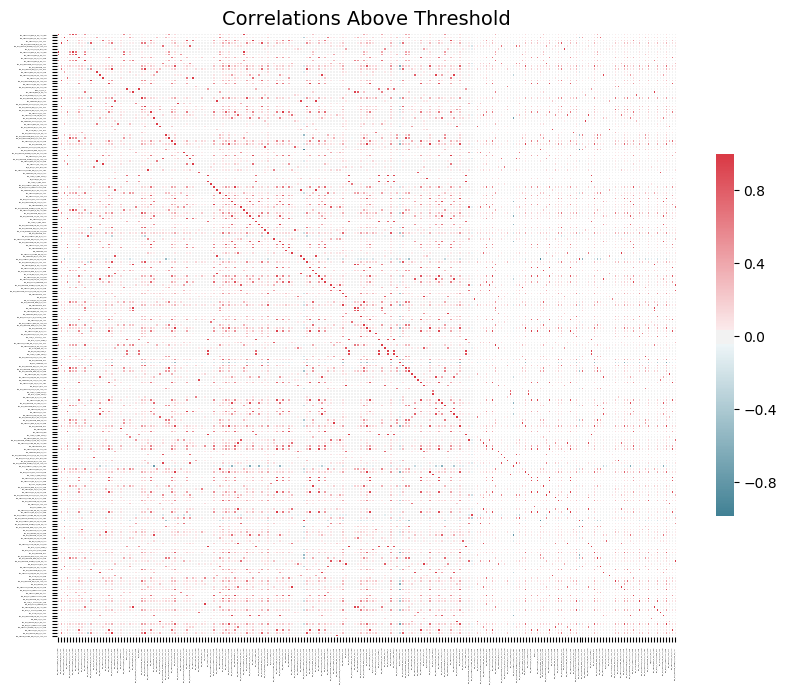

In [35]:
fs.plot_collinear()

In [26]:
# list of collinear features to remove
collinear_features = fs.ops['collinear']

# dataframe of collinear features
fs.record_collinear

,corr_feature,corr_value,drop_feature
0,AVG_PND_MENOS_BAL_12M,0.993367,AVG_BAL_12M
1,AVG_PND_MAS_BAL_12M,0.994612,AVG_BAL_12M
2,AVG_VENC89_06M,0.989072,AVG_PND_MAS_VENC89_12M
3,AVG_PND_MENOS_PCT_VENC30M_12M,0.982284,AVG_PND_MENOS_PCT_VENC60M_12M
4,AVG_AVG2_VP_MES_U06M_2,1.000000,AVG_MAX_VP_MES_U06M_2
5,AVG_AVG1_VP_PER_U06M_2,0.999898,AVG_MAX_VP_PER_U06M_2
6,AVG_AVG2_VP_MES_U03M_2,1.000000,AVG_MIN_VP_MES_U03M_2
7,MAX_AVG2_VP_MES_U03M,1.000000,MAX_AVG2_VP_MES_U03M_2
8,MAX_AVG2_VP_MES_U03M,1.000000,MAX_MAX_VP_MES_U03M_2
9,MAX_AVG2_VP_MES_U03M_2,1.000000,MAX_MAX_VP_MES_U03M_2


In [7]:
for k in range(5, 10):
    data_file_name = "PROCESSED_DATA/DATA_PREPROCESSED_PART{}.csv".format(k)
    data_file_key = "{}/{}".format(prefix, data_file_name)
    print(data_file_key)
    
    print('Loading data')
    data_part_obj = s3_bucket_resource.Object(data_file_key).get()
    data_part = pd.read_csv(io.BytesIO(data_part_obj['Body'].read()))
    display(data_part)
    #break

    params = {'objective': 'binary:logistic', 'eta':0.3, 'max_depth': 10, 'eval_metric': 'auc'}
    num_round = 100
    
    # Trianing
    dtrain = xgb.DMatrix(data_part.loc[:,:].values, label=data_target[target].values, feature_names=data_part.columns)
    bst = xgb.train(params, dtrain, num_round)
    
    feat_imp = get_xgb_feat_importances(bst)
    display(feat_imp)
    
    print('Uploading feature importance')
    feature_selection_part_file_name = "FEATURE_SELECTION/FEATURE_IMPORTANCE_PART{}.csv".format(k)
    feature_selection_part_obj_key =  "{}/{}".format(prefix, feature_selection_part_file_name)    

    f_str = io.StringIO()
    feat_imp.to_csv(f_str, index=False)
    s3_bucket_resource.Object(feature_selection_part_obj_key).put(Body=f_str.getvalue())        
    print('Upload step: ', k)

 

datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART5.csv
Loading data


,REVOLVENTE,MIN_BAL_03M,AVG_BAL_06M,MAX_BAL_12M,MAX_CRED_LIM_12M,D_CRED_LIM_TO_BAL,DS_CL,BK12_CLEAN,BK12_IND_QCRA,BK12_NUM_CRED,...,PCT_BRG_LSE_CF_OP_ACC,PCT_BRG_LSE_PQ_CL_ACC,PCT_BRG_LSG_OP_ACC,PCT_GBN_CF_OP_ACC,PCT_GBN_LSG_OP_ACC,PCT_GBN_OP_ACC,PCT_LSE_OTHER_CL_ACC,PCT_LSE_PQ_OP_ACC,PCT_UN_CRE_LSG_CL_ACC,PCT_UN_CRE_R_CL_ACC
0,0.0,-0.330463,-0.361597,-0.413010,-0.351852,-0.079525,0.548152,-0.5,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,-0.329502,-0.361177,-0.412337,-0.351852,-0.081389,0.473735,-0.5,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,-0.329502,-0.360744,-0.411635,-0.351852,-0.083335,0.458658,-0.5,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,-0.331133,-0.360939,-0.411635,-0.351852,-0.078227,0.414397,-0.5,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,1.036932,1.086687,0.787113,0.518519,-0.278586,0.917802,1.5,1.0,-0.03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,1.036932,1.085077,0.787113,0.518519,-0.287975,0.904183,1.5,1.0,-0.03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,1.366106,1.084944,0.787113,0.518519,-0.310150,0.888619,1.0,1.0,-0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,1.366106,1.084269,0.787113,0.518519,-0.282448,0.874027,1.0,1.0,-0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,1.368097,1.084544,0.787113,0.518519,-0.289986,0.859922,1.0,1.0,-0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,1.036954,1.001684,0.786824,0.518519,0.357423,0.814202,1.0,0.0,-0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


[18:02:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1152 extra nodes, 0 pruned nodes, max_depth=10
[18:02:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1220 extra nodes, 0 pruned nodes, max_depth=10
[18:02:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=10
[18:02:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1172 extra nodes, 0 pruned nodes, max_depth=10
[18:02:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1186 extra nodes, 0 pruned nodes, max_depth=10
[18:02:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1066 extra nodes, 0 pruned nodes, max_depth=10
[18:02:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1228 extra nodes, 0 pruned nodes, max_depth=10
[18:02:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_d

[18:04:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[18:04:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[18:04:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=10
[18:04:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[18:04:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[18:04:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 0 pruned nodes, max_depth=10
[18:04:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[18:04:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10


,Feature,Importance
0,D_CRED_LIM_TO_BAL,0.055176
1,MIN_BAL_03M,0.031979
2,DS_CL,0.030867
3,AVG_BAL_06M,0.030675
4,MAX_MS_OP_BRG_R_OP_ACC,0.030598
5,NBK12_PCT_PROMT,0.026419
6,MAX_BAL_12M,0.025844
7,AVG_AVG1_VP_MES_U12M_2,0.020322
8,MAX_SALINI_OP_ACC_06M,0.019057
9,AVG_PND_MENOS_MAX_HI_CALCAR_FLOOR_06M,0.018750


Uploading feature importance
Upload step:  5
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART6.csv
Loading data


,MAX_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_PND_MENOS_CRED_LIM_06M,MIN_D_CRED_LIM_TO_BAL_03M,AVG_PND_MENOS_D_CRED_LIM_TO_BAL_03M,AVG_PND_MAS_D_CRED_LIM_TO_BAL_03M,MAX_D_CRED_LIM_TO_BAL_06M,AVG_PND_MAS_D_CRED_LIM_TO_BAL_06M,MAX_D_CRED_LIM_TO_BAL_12M,MIN_D_CRED_LIM_TO_BAL_12M,...,PCT_BK_PQ_OP_ACC,PCT_BRG_LSE_CL_ACC,PCT_BRG_LSE_OP_ACC,PCT_BRG_LSE_OTHER_OP_ACC,PCT_LSE_LSG_OP_ACC,PCT_OTHER_FIN_CS_OP_ACC,PCT_OTHER_FIN_LSG_OP_ACC,PCT_OTHER_FIN_PQ_OP_ACC,PCT_OTHER_FIN_R_CL_ACC,PCT_UN_CRE_LSG_OP_ACC
0,-0.376146,-0.350217,-0.340003,0.019284,-0.093064,-0.098270,-0.079525,-0.106431,-0.079525,0.303742,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,-0.375386,-0.349388,-0.340003,0.016625,-0.094953,-0.100128,-0.081389,-0.107887,-0.081389,0.298785,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,-0.374593,-0.348894,-0.340003,0.013848,-0.095611,-0.101237,-0.083335,-0.109146,-0.083335,0.293610,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,-0.374593,-0.350339,-0.340003,0.013848,-0.095890,-0.097994,-0.078227,-0.107274,-0.078227,0.293610,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,0.970431,1.057358,0.547783,-0.283939,-0.106359,-0.174181,-0.278586,-0.200947,-0.278586,-0.317045,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.052632,0.0,0.052632,0.0
5,0.970431,1.086481,0.547783,-0.283939,-0.041099,-0.239490,-0.287975,-0.222494,-0.287975,-0.317045,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.052632,0.0,0.052632,0.0
6,0.977798,1.119445,0.547783,-0.309721,-0.305391,-0.313413,-0.310150,-0.250503,-0.310150,-0.317045,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.055556,0.0,0.055556,0.0
7,0.977798,1.117712,0.547783,-0.309721,-0.304463,-0.309527,-0.282448,-0.271634,-0.282448,-0.317045,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.055556,0.0,0.055556,0.0
8,0.977798,1.117747,0.547783,-0.309721,-0.310160,-0.309605,-0.289986,-0.295033,-0.289986,-0.317045,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.055556,0.0,0.055556,0.0
9,0.969578,0.857682,0.547783,-0.280954,0.088304,0.273593,0.357423,0.100235,0.357423,-0.314918,...,0.050000,0.000000,0.000000,0.000000,0.000000,0.0,0.050000,0.0,0.050000,0.0


[18:05:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1170 extra nodes, 0 pruned nodes, max_depth=10
[18:05:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1114 extra nodes, 0 pruned nodes, max_depth=10
[18:05:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1216 extra nodes, 0 pruned nodes, max_depth=10
[18:05:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1262 extra nodes, 0 pruned nodes, max_depth=10
[18:06:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1276 extra nodes, 0 pruned nodes, max_depth=10
[18:06:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1322 extra nodes, 0 pruned nodes, max_depth=10
[18:06:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1254 extra nodes, 0 pruned nodes, max_depth=10
[18:06:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1194 extra nodes, 0 pruned nodes, max_d

[18:08:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[18:08:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[18:08:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[18:08:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[18:08:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[18:08:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[18:08:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[18:08:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=10


,Feature,Importance
0,AVG_R_BAL_BY_CRED_LIM_06M,0.025194
1,AVG_PND_MAS_R_BAL_BY_CRED_LIM_03M,0.023996
2,MIN_D_CRED_LIM_TO_BAL_12M,0.023706
3,AVG_MS_OP_BRG_R_OP_ACC,0.022762
4,MAX_BAL_03M,0.021637
5,MAX_SALINI_CL_ACC,0.019821
6,AVG_PND_MAS_BAL_03M,0.018297
7,AVG_MS_OP_OP_ACC,0.017607
8,MAX_MS_OP_OP_ACC,0.017389
9,MAX_D_CRED_LIM_TO_BAL_06M,0.017135


Uploading feature importance
Upload step:  6
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART7.csv
Loading data


,CUR_BAL,AVG_PND_MAS_BAL_06M,MAX_CRED_LIM_03M,AVG_PND_MAS_CRED_LIM_03M,MAX_CRED_LIM_06M,AVG_PND_MAS_CRED_LIM_12M,MIN_R_BAL_BY_MAX_BAL_06M,BK12_PC_SAT,MONTHS_SINCE_LAST_OPEN_BANKING,MIN_VENC29_06M,...,NUM_LSE_R_CL_ACC,NUM_UN_CRE_OP_ACC,PCT_BRG_LSE_CF_CL_ACC,PCT_BRG_OP_ACC,PCT_CL_ACC,PCT_GBN_CS_OP_ACC,PCT_LSE_OP_ACC,PCT_LSE_OTHER_OP_ACC,PCT_OTHER_FIN_CF_CL_ACC,PCT_OTHER_FIN_OTHER_CL_ACC
0,-0.334026,-0.357544,-0.340741,-0.339623,-0.349265,-0.341825,0.420944,0.00,0.0,0.0,...,0.0,0.0,0.0,0.761538,0.373333,0.0,0.000000,0.000000,0.0,0.000000
1,-0.333211,-0.356894,-0.340741,-0.339623,-0.349265,-0.341825,0.420944,0.00,0.0,0.0,...,0.0,0.0,0.0,0.761538,0.373333,0.0,0.000000,0.000000,0.0,0.000000
2,-0.332360,-0.356332,-0.340741,-0.339623,-0.349265,-0.341825,0.420944,0.00,0.0,0.0,...,0.0,0.0,0.0,0.761538,0.373333,0.0,0.000000,0.000000,0.0,0.000000
3,-0.334594,-0.357168,-0.340741,-0.339623,-0.349265,-0.341825,-1.213896,0.00,0.0,0.0,...,0.0,0.0,0.0,0.761538,0.373333,0.0,0.000000,0.000000,0.0,0.000000
4,1.104027,1.069822,0.529630,0.547170,0.514706,0.550717,0.396228,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.734818,0.196491,0.0,0.000000,0.000000,0.0,0.000000
5,1.108131,1.079442,0.529630,0.547170,0.514706,0.550717,0.396228,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.734818,0.196491,0.0,0.000000,0.000000,0.0,0.000000
6,1.117825,1.091947,0.529630,0.547170,0.514706,0.550717,0.396228,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.705128,0.311111,0.0,0.000000,0.000000,0.0,0.000000
7,1.105715,1.101381,0.529630,0.547170,0.514706,0.550717,0.396228,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.705128,0.311111,0.0,0.000000,0.000000,0.0,0.000000
8,1.109010,1.111827,0.529630,0.547170,0.514706,0.550717,0.396228,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.705128,0.311111,0.0,0.000000,0.000000,0.0,0.000000
9,0.826012,0.935356,0.529630,0.547170,0.514706,0.550717,-0.059131,0.00,0.0,0.0,...,0.0,0.0,0.0,-0.761538,0.373333,0.0,0.000000,0.000000,0.0,0.000000


[18:09:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1094 extra nodes, 0 pruned nodes, max_depth=10
[18:09:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 0 pruned nodes, max_depth=10
[18:09:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1144 extra nodes, 0 pruned nodes, max_depth=10
[18:09:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes, 0 pruned nodes, max_depth=10
[18:09:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1102 extra nodes, 0 pruned nodes, max_depth=10
[18:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 0 pruned nodes, max_depth=10
[18:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1024 extra nodes, 0 pruned nodes, max_depth=10
[18:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1018 extra nodes, 0 pruned nodes, max_de

[18:14:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[18:15:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[18:15:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[18:15:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[18:15:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[18:15:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[18:15:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[18:15:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 730 extra nodes, 0 pruned nodes, max_depth=10


,Feature,Importance
0,MIN_R_BAL_BY_MAX_BAL_06M,0.052627
1,CUR_BAL,0.038506
2,AVG_PND_MAS_BAL_06M,0.032823
3,AVG_AVG1_VP_MES_U03M,0.023706
4,MAX_AVG2_VP_MES_U12M,0.023324
5,AVG_PND_MENOS_MAX_HI_CALCAR_CEIL_12M,0.022815
6,PCT_CL_ACC,0.020652
7,PCT_BRG_OP_ACC,0.020440
8,AVG_PND_MAS_AVG_HI_CALCAR_CEIL_12M,0.019041
9,MIN_SALINI_OP_ACC_12M,0.018871


Uploading feature importance
Upload step:  7
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART8.csv
Loading data


,MAX_BAL_06M,CUR_CRED_LIM,MIN_CRED_LIM_03M,AVG_PND_MAS_R_BAL_BY_CRED_LIM_12M,MAX_R_BAL_BY_MAX_BAL_03M,BK_IND_PMOR,MAX_FD_CALCAR_L,MAX_FD_CALCAR_FLOOR,MAX_VENC29_03M,MAX_VENC29_12M,...,PCT_BRG_CF_CL_ACC,PCT_BRG_R_CL_ACC,PCT_BRG_R_OP_ACC,PCT_GBN_R_CL_ACC,PCT_LSE_R_CL_ACC,PCT_OTHER_FIN_CF_OP_ACC,PCT_OTHER_FIN_OTHER_OP_ACC,PCT_OTHER_FIN_PQ_CL_ACC,PCT_UN_CRE_CS_OP_ACC,PCT_UN_CRE_PQ_CL_ACC
0,-0.393970,-0.339623,-0.340691,-1.692750,0.000000,-0.374000,0.0,0.000000,0.0,0.000,...,0.0,2.600000,1.348148,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.393243,-0.339623,-0.340691,-1.678388,0.000000,-0.374000,0.0,0.000000,0.0,0.000,...,0.0,2.600000,1.348148,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.392484,-0.339623,-0.340691,-1.664785,0.000000,-0.374000,0.0,0.000000,0.0,0.000,...,0.0,2.600000,1.348148,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.392484,-0.339623,-0.340691,-1.679611,0.000000,-0.374000,0.0,0.000000,0.0,0.000,...,0.0,2.600000,1.348148,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.901715,0.547170,0.595378,0.674053,-0.005797,1.106769,2.0,0.333333,19.0,193.125,...,0.0,0.684211,-0.354776,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.901416,0.547170,0.595378,0.678477,-0.005797,1.106769,2.0,0.333333,19.0,193.125,...,0.0,0.684211,-0.354776,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.900610,0.547170,0.595378,0.685356,0.000000,1.106769,2.0,0.285714,9.0,193.125,...,0.0,0.722222,-0.320988,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.900610,0.547170,0.595378,0.689152,0.000000,1.106769,2.0,0.285714,9.0,193.125,...,0.0,0.722222,-0.320988,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.900610,0.547170,0.595378,0.693844,0.000000,1.106769,2.0,0.285714,9.0,193.125,...,0.0,0.722222,-0.320988,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.900610,0.547170,0.595378,0.516592,-0.135614,1.106769,2.0,1.095238,8.0,187.500,...,0.0,0.650000,-0.385185,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[18:18:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1182 extra nodes, 0 pruned nodes, max_depth=10
[18:18:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1166 extra nodes, 0 pruned nodes, max_depth=10
[18:18:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1092 extra nodes, 0 pruned nodes, max_depth=10
[18:19:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1104 extra nodes, 0 pruned nodes, max_depth=10
[18:19:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1084 extra nodes, 0 pruned nodes, max_depth=10
[18:19:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1202 extra nodes, 0 pruned nodes, max_depth=10
[18:19:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1068 extra nodes, 0 pruned nodes, max_depth=10
[18:19:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1028 extra nodes, 0 pruned nodes, max_d

[18:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[18:25:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[18:25:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[18:25:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=10
[18:25:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[18:25:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[18:25:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[18:25:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10


,Feature,Importance
0,AVG_PND_MAS_R_BAL_BY_CRED_LIM_12M,0.067220
1,MAX_BAL_06M,0.041099
2,MAX_R_BAL_BY_MAX_BAL_03M,0.026477
3,AVG_MS_OP_BRG_OP_ACC,0.023750
4,SUM_VIGENTEH_12M,0.023276
5,AVG_VIGENTEC_BRG_R_OP_ACC_12M,0.023157
6,AVG_MS_CL_CL_ACC,0.020944
7,MIN_MS_OP_BRG_R_OP_ACC,0.020391
8,MAX_VIGENTEC_OP_ACC_03M,0.020352
9,PCT_BRG_R_OP_ACC,0.019759


Uploading feature importance
Upload step:  8
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/PROCESSED_DATA/DATA_PREPROCESSED_PART9.csv
Loading data


,MIN_BAL_06M,MIN_BAL_12M,AVG_PND_MENOS_CRED_LIM_03M,AVG_CRED_LIM_06M,AVG_D_CRED_LIM_TO_BAL_03M,R_BAL_BY_CRED_LIM,AVG_PND_MENOS_R_BAL_BY_MAX_BAL_03M,AVG_R_BAL_BY_MAX_BAL_03M,BK12_NUM_EXP_PAIDONTIME,NBK12_COMM_PCT_PLUS,...,NUM_LSE_CF_CL_ACC,NUM_LSE_CS_OP_ACC,NUM_LSE_LSG_OP_ACC,NUM_OTHER_FIN_R_CL_ACC,NUM_UN_CRE_LSG_CL_ACC,NUM_UN_CRE_R_OP_ACC,PCT_BK_OP_ACC,PCT_BRG_LSE_OTHER_CL_ACC,PCT_BRG_OTHER_CL_ACC,PCT_LSE_CF_CL_ACC
0,-0.315335,-0.297711,-0.339623,-0.339623,-0.098578,-1.453156,0.406303,0.406312,0.00,-0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.444444,0.0,0.0,0.0
1,-0.315335,-0.297711,-0.339623,-0.339623,-0.100443,-1.433450,0.406303,0.406312,0.00,-0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.444444,0.0,0.0,0.0
2,-0.315335,-0.297711,-0.339623,-0.339623,-0.101417,-1.412878,0.406303,0.406312,0.00,-0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.444444,0.0,0.0,0.0
3,-0.316069,-0.298618,-0.339623,-0.339623,-0.099835,-1.466877,-0.604682,-1.978982,0.00,-0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.444444,0.0,0.0,0.0
4,1.184113,1.555460,0.547170,0.547170,-0.143234,0.596788,0.366816,0.377155,0.00,2.00,...,0.0,0.0,0.0,1.0,0.0,0.0,1.029240,0.0,0.0,0.0
5,1.184113,1.555460,0.547170,0.547170,-0.143801,0.602741,0.393761,0.393334,0.00,2.00,...,0.0,0.0,0.0,1.0,0.0,0.0,1.029240,0.0,0.0,0.0
6,1.184113,1.555460,0.547170,0.547170,-0.311328,0.616805,0.394653,0.396578,0.00,2.25,...,0.0,0.0,0.0,1.0,0.0,0.0,0.888889,0.0,0.0,0.0
7,1.184113,1.555460,0.547170,0.547170,-0.308920,0.599237,0.385326,0.382497,0.00,2.25,...,0.0,0.0,0.0,1.0,0.0,0.0,0.888889,0.0,0.0,0.0
8,1.184113,1.555460,0.547170,0.547170,-0.311771,0.604017,0.385830,0.379035,0.00,2.25,...,0.0,0.0,0.0,1.0,0.0,0.0,0.888889,0.0,0.0,0.0
9,1.184138,1.555460,0.547170,0.547170,0.177540,0.193444,0.080766,-0.298280,0.00,2.25,...,0.0,0.0,0.0,1.0,0.0,0.0,0.955556,0.0,0.0,0.0


[18:30:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1132 extra nodes, 0 pruned nodes, max_depth=10
[18:30:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1070 extra nodes, 0 pruned nodes, max_depth=10
[18:30:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1074 extra nodes, 0 pruned nodes, max_depth=10
[18:30:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1100 extra nodes, 0 pruned nodes, max_depth=10
[18:30:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1114 extra nodes, 0 pruned nodes, max_depth=10
[18:30:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1150 extra nodes, 0 pruned nodes, max_depth=10
[18:30:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1170 extra nodes, 0 pruned nodes, max_depth=10
[18:30:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1076 extra nodes, 0 pruned nodes, max_d

[18:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=10
[18:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[18:36:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[18:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[18:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[18:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[18:37:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[18:37:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 690 extra nodes, 0 pruned nodes, max_depth=10


,Feature,Importance
0,AVG_D_CRED_LIM_TO_BAL_03M,0.038320
1,R_BAL_BY_CRED_LIM,0.036167
2,NBK12_DEUDA_TOT,0.026029
3,MIN_BAL_06M,0.024307
4,AVG_R_BAL_BY_MAX_BAL_03M,0.023329
5,AVG_PND_MENOS_R_BAL_BY_MAX_BAL_03M,0.022742
6,MIN_BAL_12M,0.022428
7,AVG_VIGENTEC_BRG_R_OP_ACC_03M,0.018553
8,AVG_SALINI_OP_ACC,0.017496
9,MIN_VIGENTEH_12M,0.014952


Uploading feature importance
Upload step:  9
